<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-+-Constants" data-toc-modified-id="Imports-+-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports + Constants</a></span></li><li><span><a href="#Create-histogram-diffs" data-toc-modified-id="Create-histogram-diffs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create histogram diffs</a></span><ul class="toc-item"><li><span><a href="#Load-saved-histograms" data-toc-modified-id="Load-saved-histograms-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load saved histograms</a></span></li><li><span><a href="#Split-NL-band" data-toc-modified-id="Split-NL-band-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Split NL band</a></span></li><li><span><a href="#Load-pairs" data-toc-modified-id="Load-pairs-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Load pairs</a></span></li><li><span><a href="#Diff-the-histograms" data-toc-modified-id="Diff-the-histograms-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Diff the histograms</a></span></li><li><span><a href="#Augment-the-diffs" data-toc-modified-id="Augment-the-diffs-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Augment the diffs</a></span></li><li><span><a href="#Standardize-the-diffs" data-toc-modified-id="Standardize-the-diffs-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Standardize the diffs</a></span></li></ul></li><li><span><a href="#OOC-Histogram-Baseline" data-toc-modified-id="OOC-Histogram-Baseline-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>OOC Histogram Baseline</a></span><ul class="toc-item"><li><span><a href="#Change-in-NL" data-toc-modified-id="Change-in-NL-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Change in NL</a></span></li><li><span><a href="#Delta-of-index" data-toc-modified-id="Delta-of-index-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Delta of index</a></span></li><li><span><a href="#Index-of-Delta" data-toc-modified-id="Index-of-Delta-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Index of Delta</a></span></li></ul></li><li><span><a href="#Incountry-Baselines" data-toc-modified-id="Incountry-Baselines-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Incountry Baselines</a></span><ul class="toc-item"><li><span><a href="#Load-Folds" data-toc-modified-id="Load-Folds-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Load Folds</a></span></li><li><span><a href="#Predict-Country-Mean" data-toc-modified-id="Predict-Country-Mean-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Predict Country Mean</a></span></li><li><span><a href="#Predict-Fold-Mean" data-toc-modified-id="Predict-Fold-Mean-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Predict Fold Mean</a></span></li><li><span><a href="#Histogram-Baseline" data-toc-modified-id="Histogram-Baseline-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Histogram Baseline</a></span></li><li><span><a href="#Single-Model" data-toc-modified-id="Single-Model-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Single Model</a></span></li></ul></li></ul></div>

This notebook assumes that `models/baselines_lsms.ipynb` has already been run.

### clone repository (only needed when working in colab)

In [ ]:
#! git clone https://github.com/DIS-ML-PROJECT/CNN_Architecture.git

# Imports + Constants

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns

sys.path.append('../')
# sys.path.append('/content/CNN_Architecture/')

from models.histograms import split_nl_hist
from models.linear_model import train_linear_model, train_linear_logo
from utils.analysis import (
    calc_score,
    evaluate,
    evaluate_df,
    sorted_scores,
    plot_label_vs_score)
from utils.general import colordisplay, load_npz
from utils.plot import scatter_preds

In [ ]:
SPLITS = ['train', 'val', 'test']
FOLDS = ['A', 'B', 'C', 'D', 'E']

LSMS_COUNTRIES = ['ethiopia', 'malawi', 'nigeria', 'tanzania', 'uganda']

# Create histogram diffs

In [ ]:
# BAND_BIN_EDGES = [-10^5, -5.0, -4.9, -4.8, ..., 4.8, 4.9, 5.0, 10^5]
# BAND_BIN_CENTERS = [-5.05, -4.95, -4.85, ..., 4.85, 4.95, 5.05]
BAND_BIN_EDGES = np.concatenate([
    [-1e5],
    np.arange(-5.0, 5.1, 0.1),
    [1e5]
])
BAND_BIN_CENTERS = np.arange(-5.05, 5.15, 0.1)

# LABEL_BIN_EDGES = [-2.0, -1.9, ..., 2.8, 2.9]
# LABEL_BIN_CENTERS = [-1.95, -1.85, ..., 2.75, 2.85]
LABEL_BIN_EDGES = np.arange(-2.0, 3.0, 0.1)
LABEL_BIN_CENTERS = np.arange(-1.95, 2.95, 0.1)

# band name => color for plotting
BAND_COLORS = {
    'BLUE'  : 'blue',
    'GREEN' : 'green',
    'RED'   : 'red',
    'SWIR1' : 'purple',
    'SWIR2' : 'brown',
    'TEMP1' : 'orange',
    'NIR'   : 'pink',
    'NIGHTLIGHTS': 'black',
    'DMSP'  : 'black',
    'VIIRS' : 'gray',
}
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
BAND_ORDER_NLSPLIT = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'DMSP', 'VIIRS']

BANDS_DICT = {
    'rgb': [0, 1, 2],
    'rgbnl': [0, 1, 2, 7, 8],
    'ms': [0, 1, 2, 3, 4, 5, 6],
    'msnl': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'nl': [7, 8],
}

## Load saved histograms

In [ ]:
result = load_npz('/content/africa_poverty/data/lsms_image_hists.npz')
image_hists = result['image_hists']
years = result['years']
nls_center = result['nls_center']
nls_mean = result['nls_mean']

image_hists: dtype=int64, shape=(3020, 8, 102)
labels: dtype=float32, shape=(3020,)
locs: dtype=float32, shape=(3020, 2)
years: dtype=int32, shape=(3020,)
nls_center: dtype=float32, shape=(3020,)
nls_mean: dtype=float32, shape=(3020,)


## Split NL band

In [ ]:
image_hists = split_nl_hist(image_hists, years)

## Load pairs

In [ ]:
file_path = '/content/africa_poverty/data/lsmsdelta_pairs.csv'
# each row refers to a pair of LSMS data points at the same location over 2 different years
delta_pairs_df = pd.read_csv(file_path, index_col=False)
delta_pairs_df.rename({
    'index': 'deltaofindex',
    'index_diff': 'indexofdelta',
    'x': 'households'
}, axis=1, inplace=True)
with pd.option_context('display.max_rows', 4):
    display(delta_pairs_df)
npairs = len(delta_pairs_df)

country_labels = np.asarray(list(map(LSMS_COUNTRIES.index, delta_pairs_df['country'])))
country_indices = {
    country: np.where(delta_pairs_df['country'] == country)[0]
    for country in LSMS_COUNTRIES
}

,lat,lon,year.x,country,year.y,deltaofindex,indexofdelta,geolev1,geolev2,households,tfrecords_index.x,tfrecords_index.y
0,-0.292248,31.478722,2005,uganda,2009,-0.369128,-1.782208,UGA.53,UGA,8,2574,2694
1,-0.292248,31.478722,2009,uganda,2013,-0.047140,-0.119516,UGA.53,UGA,8,2694,2941
...,...,...,...,...,...,...,...,...,...,...,...,...
1537,9.917938,11.689417,2010,nigeria,2015,0.700611,0.777255,NGA.16,NGA,1,1145,1626
1538,9.991906,37.692553,2011,ethiopia,2015,0.072652,0.049075,ETH.3,ETH,9,120,449


In [ ]:
country_labels

array([4, 4, 4, ..., 0, 2, 0])

## Diff the histograms

In [ ]:
labels_doi = delta_pairs_df['deltaofindex'].values
labels_iod = delta_pairs_df['indexofdelta'].values
weights = delta_pairs_df['households'].values * len(delta_pairs_df) /delta_pairs_df['households'].sum()

index1 = delta_pairs_df['tfrecords_index.x'].values # index of first year of this pair
index2 = delta_pairs_df['tfrecords_index.y'].values # index of secound year of this pair
hists_diffs = image_hists[index1] - image_hists[index2] # delta image_hists between these pairs
nls_mean_diffs = nls_mean[index2] - nls_mean[index1]  
nls_center_diffs = nls_center[index2] - nls_center[index1]

labels_doi_classes = np.ones_like(labels_doi, dtype=np.int32) 
labels_doi_classes[labels_doi < -0.125] = 0                  
labels_doi_classes[labels_doi > 0.125] = 2

labels_iod_classes = np.ones_like(labels_iod, dtype=np.int32)
labels_iod_classes[labels_iod < -0.5] = 0
labels_iod_classes[labels_iod > 0.5] = 2

## Augment the diffs

In [ ]:
# augment the diffs
hists_diffs_aug = np.concatenate([hists_diffs, -hists_diffs])                 # augment by using positive and negative values
nls_mean_diffs_aug = np.concatenate([nls_mean_diffs, -nls_mean_diffs])        
nls_center_diffs_aug = np.concatenate([nls_center_diffs, -nls_center_diffs])
labels_doi_aug = np.concatenate([labels_doi, -labels_doi])
labels_iod_aug = np.concatenate([labels_iod, -labels_iod])
weights_aug = np.tile(weights, 2)                                                     # augment by repeating values
country_labels_aug = np.tile(country_labels, 2)
country_indices_aug = {c: np.tile(indices, 2) for c, indices in country_indices.items()}

## Standardize the hist diffs

In [ ]:
hists_diffs_mean = np.mean(hists_diffs_aug, axis=0, dtype=np.float64)
hists_diffs_std = np.std(hists_diffs_aug, axis=0, dtype=np.float64)
standardized_hists_diffs = (hists_diffs_aug - hists_diffs_mean) / (hists_diffs_std + 1e-6)
print(standardized_hists_diffs.shape)

(3078, 9, 102)


# OOC Histogram Baseline

In [ ]:
def run_ooc(country, band_indices, labels_diffs_aug):
    '''

    Args:
        - country: str, name of country
        - band_indices: list of int, index of selected channels
        - labels_diffs_aug: np.array, shape [N,] dtype: float64

    Returns:
        - results_df:   pd.DataFrame, columns are ['r2', 'R2', 'mse', 'rank']
                        row index are `cols`

    '''
    test_group = LSMS_COUNTRIES.index(country)
    test_preds, coefs, intercept = train_linear_logo(
        features=standardized_hists_diffs[:, band_indices, :].reshape(npairs*2, -1),
        labels=labels_diffs_aug,
        group_labels=country_labels_aug,
        cv_groups=[i for i in range(len(LSMS_COUNTRIES)) if test_group != i],
        test_groups=[test_group],
        weights=weights_aug,
        plot=False, group_names=LSMS_COUNTRIES, return_weights=True)
    print(f'best intercept: {intercept:.4g}')
    return evaluate(test_preds, labels_diffs_aug[country_indices_aug[country]], do_print=True)

## Change in NL

In [ ]:
# limit to Uganda 2005-09 only, where we have DMSP for both
uganda0509_mask = (
    (delta_pairs_df['year.x'] == 2005) &
    (delta_pairs_df['year.y'] == 2009) &
    (delta_pairs_df['country'] == 'uganda'))
delta_nls_center = nls_center[index1[uganda0509_mask]] - nls_center[index2[uganda0509_mask]]
delta_nls_mean = nls_mean[index1[uganda0509_mask]] - nls_mean[index2[uganda0509_mask]]
nls_weights = weights[uganda0509_mask]

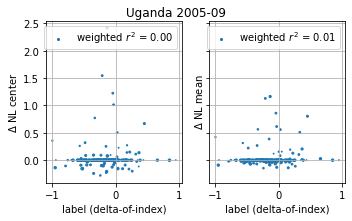

In [ ]:
r2_doi_nls_center = calc_score(labels_doi[uganda0509_mask], delta_nls_center, weights=nls_weights, metric='r2')
r2_doi_nls_mean = calc_score(labels_doi[uganda0509_mask], delta_nls_mean, weights=nls_weights, metric='r2')

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
axs[0].scatter(labels_doi[uganda0509_mask], delta_nls_center, s=nls_weights*5,
               label=f'weighted $r^2$ = {r2_doi_nls_center:.2f}')
axs[1].scatter(labels_doi[uganda0509_mask], delta_nls_mean, s=nls_weights*5,
               label=f'weighted $r^2$ = {r2_doi_nls_mean:.2f}')
axs[0].set(xlabel='label (delta-of-index)', ylabel='$\Delta$ NL center')
axs[1].set(xlabel='label (delta-of-index)', ylabel='$\Delta$ NL mean')
for ax in axs:
    ax.legend()
    ax.grid(True)
fig.suptitle('Uganda 2005-09', y=1.01)
fig.tight_layout()
plt.show()

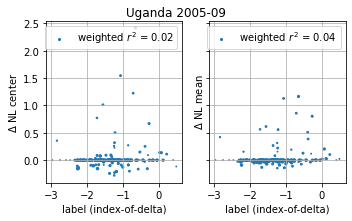

In [ ]:
r2_iod_nls_center = calc_score(labels_iod[uganda0509_mask], delta_nls_center, weights=nls_weights, metric='r2')
r2_iod_nls_mean = calc_score(labels_iod[uganda0509_mask], delta_nls_mean, weights=nls_weights, metric='r2')

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
axs[0].scatter(labels_iod[uganda0509_mask], delta_nls_center, s=nls_weights*5,
               label=f'weighted $r^2$ = {r2_iod_nls_center:.2f}')
axs[1].scatter(labels_iod[uganda0509_mask], delta_nls_mean, s=nls_weights*5,
               label=f'weighted $r^2$ = {r2_iod_nls_mean:.2f}')
axs[0].set(xlabel='label (index-of-delta)', ylabel='$\Delta$ NL center')
axs[1].set(xlabel='label (index-of-delta)', ylabel='$\Delta$ NL mean')
for ax in axs:
    ax.legend()
    ax.grid(True)
fig.suptitle('Uganda 2005-09', y=1.01)
fig.tight_layout()
plt.show()

## Delta of index

In [ ]:
rgb_df = pd.DataFrame(columns=['country', 'r2', 'R2', 'mse', 'rank'], dtype=np.float64)
rgb_df.set_index('country', inplace=True)
for country in LSMS_COUNTRIES:
    print(f'=== {country} ===')
    rgb_df.loc[country, :] = run_ooc(country, band_indices=BANDS_DICT['rgb'],
                                     labels_diffs_aug=labels_doi_aug)
display(rgb_df)

=== ethiopia ===
best val mse: 0.103, best alpha: 8192.0, test mse: 0.053
best intercept: -6.156e-18
r^2: 0.000, R^2: -49.071, mse: 0.063, rank: 0.000
=== malawi ===
best val mse: 0.099, best alpha: 1024.0, test mse: 0.020
best intercept: -2.692e-18
r^2: 0.000, R^2: -6.350, mse: 0.027, rank: 0.000
=== nigeria ===
best val mse: 0.060, best alpha: 1024.0, test mse: 0.153
best intercept: -1.151e-17
r^2: 0.000, R^2: -7.016, mse: 0.225, rank: 0.000
=== tanzania ===
best val mse: 0.084, best alpha: 1024.0, test mse: 0.108
best intercept: 4.861e-18
r^2: 0.000, R^2: -20.646, mse: 0.128, rank: 0.000
=== uganda ===
best val mse: 0.089, best alpha: 1024.0, test mse: 0.080
best intercept: -1.068e-18
r^2: 0.000, R^2: -43.605, mse: 0.100, rank: 0.000


,r2,R2,mse,rank
country,,,,
ethiopia,8.301487e-35,-49.070991,0.062541,0.0
malawi,7.746235e-36,-6.350232,0.026927,0.0
nigeria,8.565692e-35,-7.015872,0.225233,0.0
tanzania,2.884519e-37,-20.645716,0.127731,0.0
uganda,6.376906e-37,-43.604845,0.100393,0.0


In [ ]:
msnl_df = pd.DataFrame(columns=['country', 'r2', 'R2', 'mse', 'rank'], dtype=np.float64)
msnl_df.set_index('country', inplace=True)
for country in LSMS_COUNTRIES:
    print(f'=== {country} ===')
    msnl_df.loc[country, :] = run_ooc(country, band_indices=BANDS_DICT['msnl'],
                                      labels_diffs_aug=labels_doi_aug)
display(msnl_df)

=== ethiopia ===
best val mse: 0.103, best alpha: 65536.0, test mse: 0.054
best intercept: 8.482e-19
r^2: 0.000, R^2: -111.068, mse: 0.062, rank: 0.000
=== malawi ===
best val mse: 0.100, best alpha: 8192.0, test mse: 0.021
best intercept: 1.175e-17
r^2: 0.000, R^2: -3.278, mse: 0.030, rank: 0.000
=== nigeria ===
best val mse: 0.061, best alpha: 8192.0, test mse: 0.153
best intercept: 3.098e-18
r^2: 0.000, R^2: -38.164, mse: 0.202, rank: 0.000
=== tanzania ===
best val mse: 0.084, best alpha: 8192.0, test mse: 0.107
best intercept: -3.133e-19
r^2: 0.000, R^2: -15.035, mse: 0.130, rank: 0.000
=== uganda ===
best val mse: 0.089, best alpha: 8192.0, test mse: 0.079
best intercept: 9.472e-18
r^2: 0.000, R^2: -59.130, mse: 0.100, rank: 0.000


,r2,R2,mse,rank
country,,,,
ethiopia,1.143116e-34,-111.067572,0.061843,0.0
malawi,2.639900e-35,-3.277641,0.030361,0.0
nigeria,1.392793e-35,-38.164377,0.202300,0.0
tanzania,5.240160e-35,-15.035033,0.129933,0.0
uganda,1.843495e-35,-59.129783,0.099802,0.0


## Index of Delta

In [ ]:
rgb_df = pd.DataFrame(columns=['country', 'r2', 'R2', 'mse', 'rank'], dtype=np.float64)
rgb_df.set_index('country', inplace=True)
for country in LSMS_COUNTRIES:
    print(f'=== {country} ===')
    rgb_df.loc[country, :] = run_ooc(country, band_indices=BANDS_DICT['rgb'],
                                     labels_diffs_aug=labels_iod_aug)
display(rgb_df)

=== ethiopia ===
best val mse: 0.517, best alpha: 65536.0, test mse: 0.159
best intercept: -1.871e-17
r^2: 0.000, R^2: -300.707, mse: 0.174, rank: 0.000
=== malawi ===
best val mse: 0.476, best alpha: 65536.0, test mse: 0.063
best intercept: -2.069e-17
r^2: 0.000, R^2: -213.865, mse: 0.073, rank: 0.000
=== nigeria ===
best val mse: 0.398, best alpha: 8192.0, test mse: 0.452
best intercept: -1.003e-17
r^2: 0.000, R^2: -27.008, mse: 0.561, rank: 0.000
=== tanzania ===
best val mse: 0.433, best alpha: 65536.0, test mse: 0.229
best intercept: 5.681e-18
r^2: 0.000, R^2: -215.629, mse: 0.316, rank: 0.000
=== uganda ===
best val mse: 0.249, best alpha: 8192.0, test mse: 1.095
best intercept: -6.074e-18
r^2: 0.000, R^2: -592.164, mse: 1.164, rank: 0.000


,r2,R2,mse,rank
country,,,,
ethiopia,3.432204e-35,-300.706596,0.174212,0.0
malawi,4.306806e-35,-213.864953,0.073034,0.0
nigeria,3.178703e-36,-27.007505,0.561268,0.0
tanzania,2.586105e-35,-215.628736,0.315509,0.0
uganda,2.715230e-34,-592.163502,1.164130,0.0


In [ ]:
msnl_df = pd.DataFrame(columns=['country', 'r2', 'R2', 'mse', 'rank'], dtype=np.float64)
msnl_df.set_index('country', inplace=True)
for country in LSMS_COUNTRIES:
    print(f'=== {country} ===')
    msnl_df.loc[country, :] = run_ooc(country, band_indices=BANDS_DICT['msnl'],
                                      labels_diffs_aug=labels_iod_aug)
display(msnl_df)

=== ethiopia ===
best val mse: 0.516, best alpha: 65536.0, test mse: 0.157
best intercept: -1.783e-17
r^2: 0.000, R^2: -136.761, mse: 0.175, rank: 0.000
=== malawi ===
best val mse: 0.476, best alpha: 65536.0, test mse: 0.058
best intercept: -1.424e-17
r^2: 0.000, R^2: -9.607, mse: 0.080, rank: 0.000
=== nigeria ===
best val mse: 0.402, best alpha: 65536.0, test mse: 0.442
best intercept: -2.777e-18
r^2: 0.000, R^2: -154.206, mse: 0.545, rank: 0.000
=== tanzania ===
best val mse: 0.432, best alpha: 65536.0, test mse: 0.230
best intercept: 5.409e-18
r^2: 0.000, R^2: -76.567, mse: 0.318, rank: 0.000
=== uganda ===
best val mse: 0.249, best alpha: 65536.0, test mse: 1.100
best intercept: 1.867e-18
r^2: 0.000, R^2: -1223.195, mse: 1.163, rank: 0.000


,r2,R2,mse,rank
country,,,,
ethiopia,4.347482e-35,-136.761421,0.174905,0.0
malawi,3.963499e-35,-9.607446,0.080261,0.0
nigeria,4.736864e-35,-154.206227,0.544738,0.0
tanzania,3.245961e-38,-76.567422,0.318154,0.0
uganda,3.359943e-34,-1223.194643,1.163117,0.0


# Incountry Baselines

## Load Folds

In [ ]:
with open('/content/africa_poverty/data/lsms_incountry_folds.pkl', 'rb') as f:
    incountry_folds = pickle.load(f)

In [ ]:
incountry_group_labels_aug = np.zeros(npairs * 2, dtype=np.int32)

for i, f in enumerate(FOLDS):
    fold_mask = delta_pairs_df[['tfrecords_index.x', 'tfrecords_index.y']].isin(incountry_folds[f]['test']).values
    assert np.all(fold_mask[:, 0] == fold_mask[:, 1])
    fold_mask = np.tile(fold_mask[:, 0], 2)
    incountry_group_labels_aug[fold_mask] = i

## Predict Country Mean

In [ ]:
###############################################################################################
#EDIT:    'labels_diffs' changed to 'labels_doi' and
#         'labels_diffs_aug' changed to 'labels_doi_aug'
#         since there were no such variables
###############################################################################################
mean_preds = np.zeros(npairs)
for i, country in enumerate(LSMS_COUNTRIES):
    indices = np.where(country_labels == i)[0]
    mean_preds[indices] = np.mean(labels_doi_aug[indices])
r2, R2, mse, rank = evaluate(labels_doi, mean_preds, do_print=True)

r^2: 0.132, R^2: 0.132, mse: 0.099, rank: 0.345


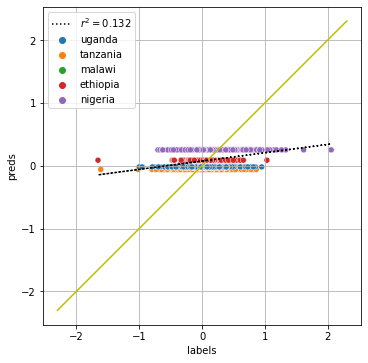

In [ ]:
###############################################################################################
#EDIT:    'labels_diffs' changed to 'labels_doi'
#         since there was no no variable labels_diffs
###############################################################################################

df = pd.DataFrame({
    'labels': labels_doi,
    'preds': mean_preds,
    'country': np.asarray(LSMS_COUNTRIES)[country_labels]
})
fig, ax = plt.subplots(1, 1, figsize=[5, 5], constrained_layout=True)
m, b = np.polyfit(df['labels'], df['preds'], 1)
ax.plot([-2.3, 2.3], [-2.3, 2.3], '-y')
sns.scatterplot(data=df, x='labels', y='preds', hue='country', ax=ax)
ax.plot(df['labels'], m*df['labels']+b, ':k', label=f'$r^2={r2:.3g}$')
ax.set_aspect('equal')
ax.legend()
ax.grid(True)

In [ ]:
###############################################################################################
#EDIT:    'labels_diffs_classes' changed to 'labels_doi_classes'
#         since there was no no variable labels_diffs_classes
###############################################################################################
for i, country in enumerate(LSMS_COUNTRIES):
    class_counts = np.zeros(3)
    indices = np.where(country_labels == i)[0]
    for j in [0, 1, 2]:
        class_counts[j] = np.sum(labels_doi_classes[indices] == j)
    normalized_class_counts = class_counts / class_counts.sum()
    print(country, np.argmax(normalized_class_counts), np.max(normalized_class_counts))

ethiopia 1 0.4923547400611621
malawi 1 0.6176470588235294
nigeria 2 0.6145833333333334
tanzania 0 0.45666666666666667
uganda 0 0.3393939393939394


## Predict Fold Mean

In [ ]:
###############################################################################################
#EDIT:    'labels_diffs' changed to 'labels_iod'
#         since there was no no variable labels_diffs
###############################################################################################
mean_preds = np.zeros(npairs)
fold_labels = np.full(shape=npairs, fill_value='_')
for i, f in enumerate(FOLDS):
    fold_mask = delta_pairs_df['tfrecords_index.x'].isin(incountry_folds[f]['test']).values
    fold_labels[fold_mask] = f
    mean_preds[fold_mask] = np.mean(labels_iod[fold_mask])
r2, R2, mse, rank = evaluate(labels_iod[:npairs], mean_preds, do_print=True)

r^2: 0.006, R^2: 0.006, mse: 0.518, rank: 0.065


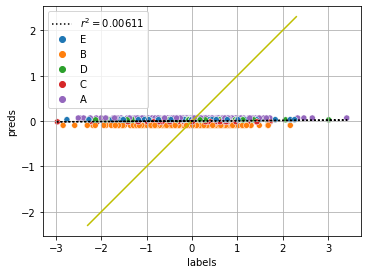

In [ ]:
###############################################################################################
#EDIT:    'labels_diffs' changed to 'labels_iod'
#         since there was no no variable labels_diffs
###############################################################################################
df = pd.DataFrame({
    'labels': labels_iod,
    'preds': mean_preds,
    'fold': fold_labels,
})
fig, ax = plt.subplots(1, 1, figsize=[5, 5], constrained_layout=True)
m, b = np.polyfit(df['labels'], df['preds'], 1)
ax.plot([-2.3, 2.3], [-2.3, 2.3], '-y')
sns.scatterplot(data=df, x='labels', y='preds', hue='fold', ax=ax)
ax.plot(df['labels'], m*df['labels']+b, ':k', label=f'$r^2={r2:.3g}$')
ax.set_aspect('equal')
ax.legend()
ax.grid(True)

In [ ]:
labels_iod.shape

(1539,)

In [ ]:
###############################################################################################
#EDIT:    'index1' changed to 'tfrecords_index.x' and
#         'labels_diffs_classes' changed to 'labels_iod_classes'
#         since there was no column index1 and no variable labels_diffs_classes
###############################################################################################


for i, f in enumerate(FOLDS):
    class_counts = np.zeros(3)
    fold_mask = delta_pairs_df['tfrecords_index.x'].isin(incountry_folds[f]['test']).values
    for j in [0, 1, 2]:
        class_counts[j] = np.sum(labels_iod_classes[fold_mask] == j)
    normalized_class_counts = class_counts / class_counts.sum()
    print(f, np.argmax(normalized_class_counts), np.max(normalized_class_counts))

A 1 0.6303630363036303
B 1 0.6211180124223602
C 1 0.6601307189542484
D 1 0.6437908496732027
E 1 0.6456953642384106


## Histogram Baseline

In [ ]:
def run_incountry(features, labels, incountry_group_labels):
    '''

    Args:
        - features: np.array, shape [N, C*nbins]
        - labels: tf.Tensor, shape [batch_size] dtype=flaot32
        - incountry_group_labels: np.array, shape [N,] dtype=int32

    Returns:
        - ndarray, test predictions

    '''
    num_examples = len(features)
    test_preds = np.zeros(num_examples, dtype=np.float32)

    do_plot = True
    for i, fold in enumerate(FOLDS):
        print('Fold:', fold)
        test_mask = (incountry_group_labels == i)
        test_preds[test_mask] = train_linear_logo(
            features=features,
            labels=labels,
            group_labels=incountry_group_labels,
            cv_groups=[x for x in range(5) if x != i],
            test_groups=[i],
            plot=do_plot,
            group_names=FOLDS)
        do_plot = False
    return test_preds

=== rgb ===
Fold: A


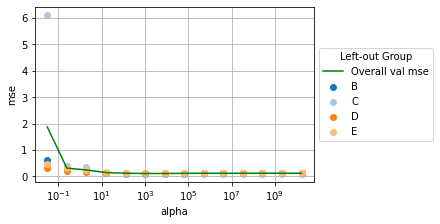

best val mse: 0.108, best alpha: 8192.0, test mse: 0.118
Fold: B
best val mse: 0.112, best alpha: 1024.0, test mse: 0.096
Fold: C
best val mse: 0.113, best alpha: 1024.0, test mse: 0.087
Fold: D
best val mse: 0.106, best alpha: 1024.0, test mse: 0.110
Fold: E
best val mse: 0.103, best alpha: 1024.0, test mse: 0.123
=== rgbnl ===
Fold: A


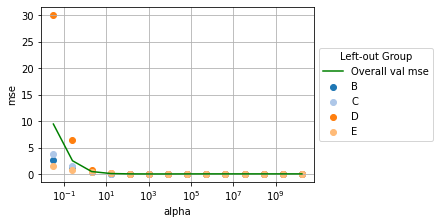

best val mse: 0.105, best alpha: 1024.0, test mse: 0.112
Fold: B
best val mse: 0.105, best alpha: 1024.0, test mse: 0.097
Fold: C
best val mse: 0.108, best alpha: 1024.0, test mse: 0.082
Fold: D
best val mse: 0.102, best alpha: 1024.0, test mse: 0.104
Fold: E
best val mse: 0.102, best alpha: 1024.0, test mse: 0.116
=== ms ===
Fold: A


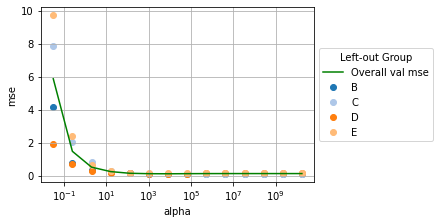

best val mse: 0.105, best alpha: 8192.0, test mse: 0.114
Fold: B
best val mse: 0.109, best alpha: 8192.0, test mse: 0.097
Fold: C
best val mse: 0.110, best alpha: 8192.0, test mse: 0.088
Fold: D
best val mse: 0.105, best alpha: 8192.0, test mse: 0.107
Fold: E
best val mse: 0.103, best alpha: 8192.0, test mse: 0.119
=== msnl ===
Fold: A


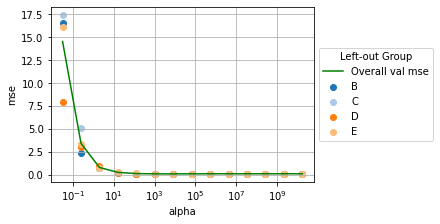

best val mse: 0.104, best alpha: 8192.0, test mse: 0.112
Fold: B
best val mse: 0.107, best alpha: 8192.0, test mse: 0.096
Fold: C
best val mse: 0.108, best alpha: 1024.0, test mse: 0.098
Fold: D
best val mse: 0.103, best alpha: 8192.0, test mse: 0.105
Fold: E
best val mse: 0.102, best alpha: 8192.0, test mse: 0.117
=== nl ===
Fold: A


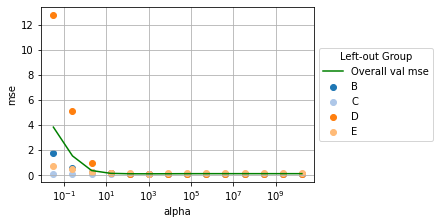

best val mse: 0.106, best alpha: 1024.0, test mse: 0.120
Fold: B
best val mse: 0.110, best alpha: 1024.0, test mse: 0.100
Fold: C
best val mse: 0.113, best alpha: 1024.0, test mse: 0.086
Fold: D
best val mse: 0.108, best alpha: 1024.0, test mse: 0.109
Fold: E
best val mse: 0.107, best alpha: 1024.0, test mse: 0.125


In [ ]:
#################################################################################
#EDIT:  'normalized_hists_diffs' changed to 'standardized_hists_diffs' and
#       'labels_diffs_aug' changed to 'labels_doi_aug'
#       since these variables were not defined
#################################################################################


test_preds_dfs = []
for bands_name, band_indices in BANDS_DICT.items():
    print('===', bands_name, '===')
    test_preds = run_incountry(
        features=standardized_hists_diffs[:, band_indices, :].reshape(npairs*2, -1),
        labels=labels_doi_aug,
        incountry_group_labels=incountry_group_labels_aug)
    test_preds_df = pd.DataFrame(data={
        'preds': test_preds,
        'labels': labels_doi_aug,
        'fold': np.asarray(FOLDS)[incountry_group_labels_aug],
        'country': np.asarray(LSMS_COUNTRIES)[country_labels_aug],
        'bands': bands_name
    })
    test_preds_dfs.append(test_preds_df)

=== nlmean ===
Fold: A


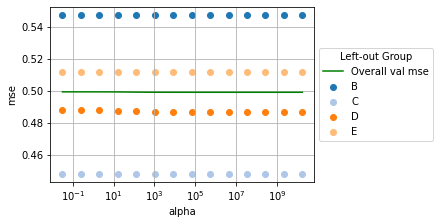

best val mse: 0.499, best alpha: 17179869184.0, test mse: 0.610
Fold: B
best val mse: 0.514, best alpha: 65536.0, test mse: 0.548
Fold: C
best val mse: 0.539, best alpha: 17179869184.0, test mse: 0.448
Fold: D
best val mse: 0.529, best alpha: 17179869184.0, test mse: 0.487
Fold: E
best val mse: 0.523, best alpha: 17179869184.0, test mse: 0.512
=== nlcenter ===
Fold: A


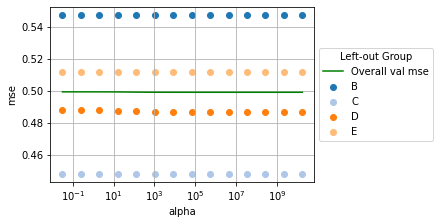

best val mse: 0.499, best alpha: 17179869184.0, test mse: 0.610
Fold: B
best val mse: 0.514, best alpha: 65536.0, test mse: 0.548
Fold: C
best val mse: 0.539, best alpha: 17179869184.0, test mse: 0.448
Fold: D
best val mse: 0.529, best alpha: 17179869184.0, test mse: 0.487
Fold: E
best val mse: 0.523, best alpha: 17179869184.0, test mse: 0.512


In [ ]:
for bands_name, features in [('nlmean', nls_mean_diffs_aug), ('nlcenter', nls_center_diffs_aug)]:
    print('===', bands_name, '===')
    test_preds = run_incountry(
        features=nls_center_diffs_aug.reshape(-1, 1),
        labels=labels_iod_aug,
        incountry_group_labels=incountry_group_labels_aug)
    test_preds_df = pd.DataFrame(data={
        'preds': test_preds,
        'labels': labels_iod_aug,
        'fold': np.asarray(FOLDS)[incountry_group_labels_aug],
        'country': np.asarray(LSMS_COUNTRIES)[country_labels_aug],
        'bands': bands_name
    })
    test_preds_dfs.append(test_preds_df)

In [ ]:
test_preds_df = pd.concat(test_preds_dfs).reset_index()
with pd.option_context('display.max_rows', 4):
    display(test_preds_df)

,index,preds,labels,fold,country,bands
0,0,-5.862043e-03,-0.369128,E,uganda,rgb
1,1,3.561318e-02,-0.047140,E,uganda,rgb
...,...,...,...,...,...,...
21544,3076,3.119158e-09,-0.777255,E,nigeria,nlcenter
21545,3077,2.623591e-11,-0.049075,A,ethiopia,nlcenter


In [ ]:
test_preds_df.columns

Index(['index', 'preds', 'labels', 'fold', 'country', 'bands'], dtype='object')

In [ ]:
results_df = test_preds_df.groupby('bands').apply(evaluate_df)
colordisplay(results_df)

TypeError: ignored

In [ ]:
results_cfb_df = test_preds_df.groupby(['country', 'fold', 'bands']).apply(evaluate_df)
colordisplay(results_cfb_df)

TypeError: ignored

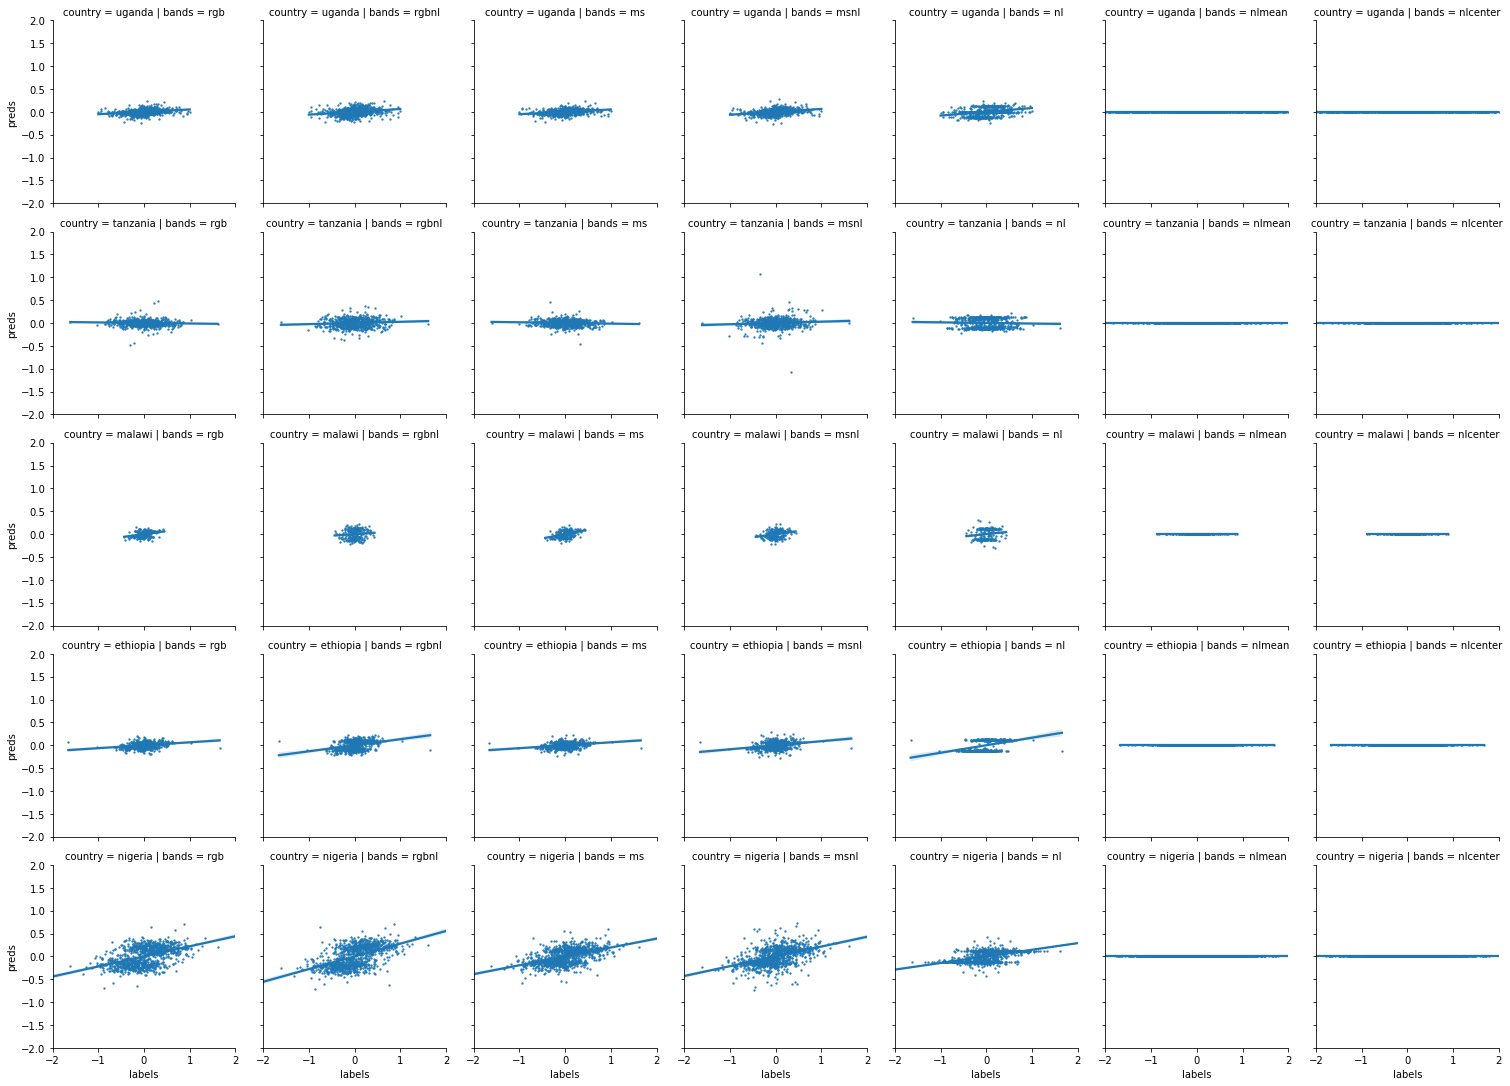

In [ ]:
g = sns.lmplot(data=test_preds_df, row='country', col='bands', x='labels', y='preds',
               height=3, truncate=True, scatter_kws={'s': 2})
g = g.set(ylim=(-2, 2), xlim=(-2, 2), aspect='equal')

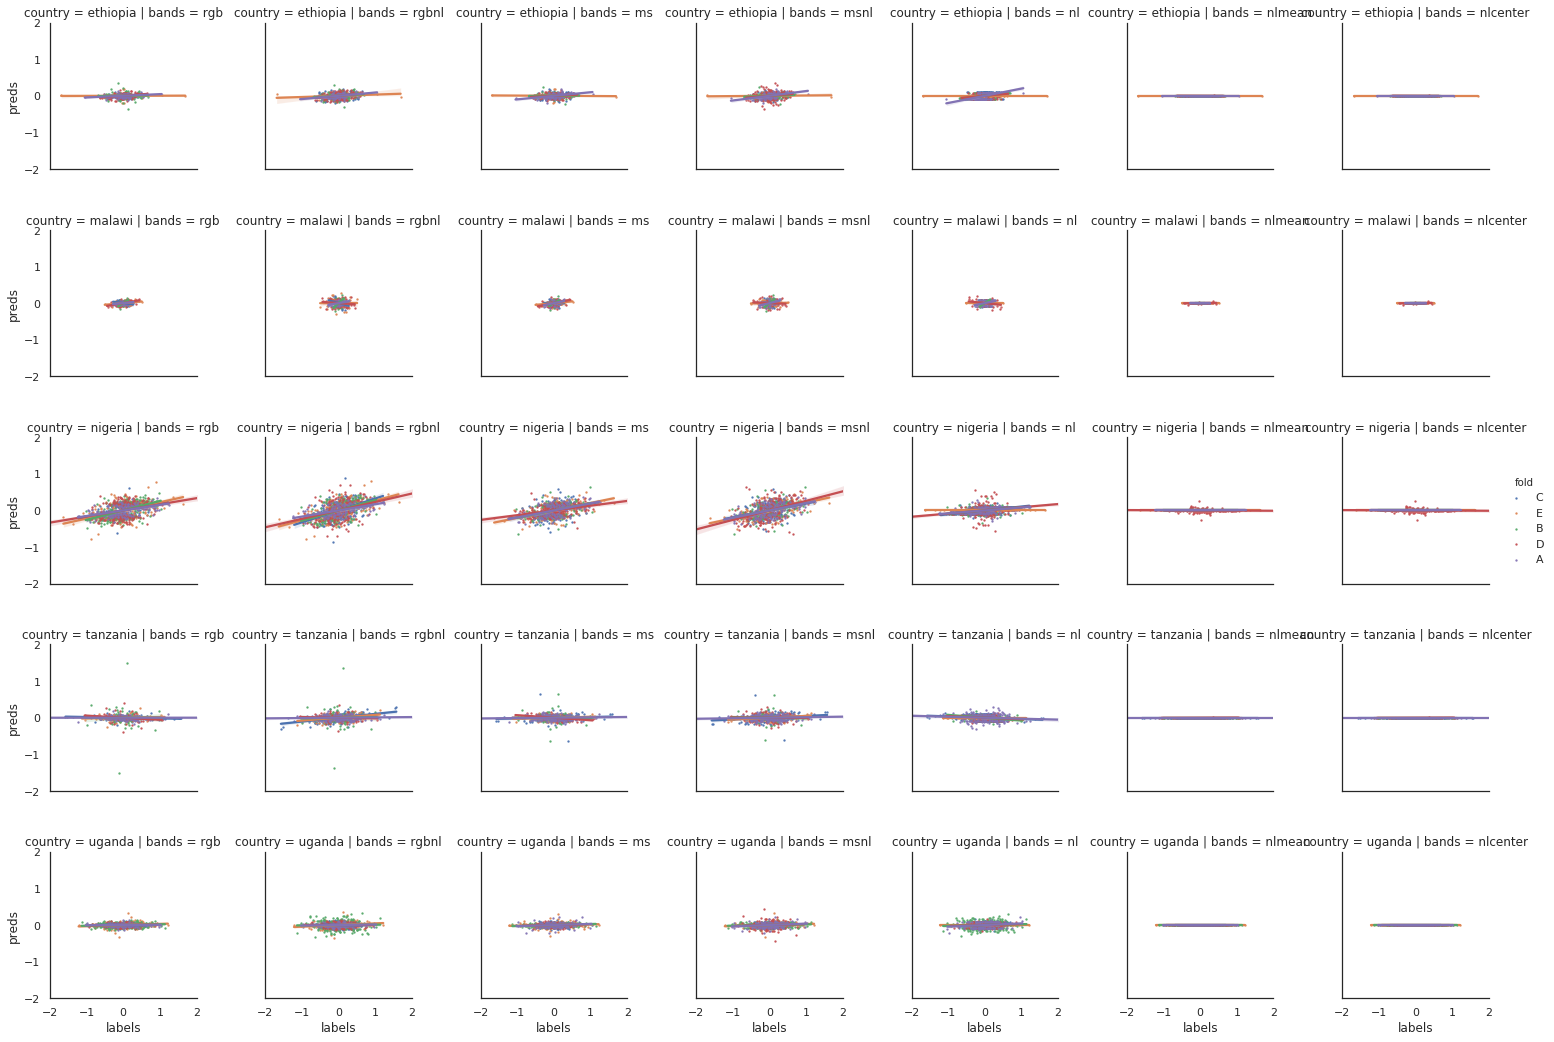

In [ ]:
g = sns.lmplot(data=test_preds_df, row='country', col='bands', hue='fold', x='labels', y='preds',
               height=3, truncate=True, scatter_kws={'s': 2})
g = g.set(ylim=(-2, 2), xlim=(-2, 2), aspect='equal')

In [ ]:
results_bycountry_df = test_preds_df.groupby(['country', 'bands']).apply(evaluate_df)
colordisplay(results_bycountry_df)

In [ ]:
results_byfold_df = test_preds_df.groupby(['fold', 'bands']).apply(evaluate_df)
colordisplay(results_byfold_df)

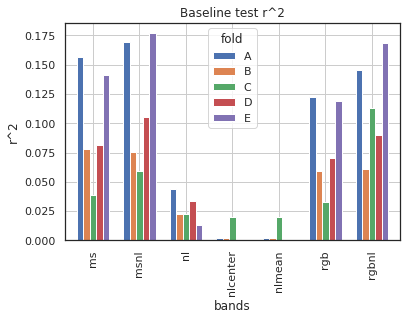

In [ ]:
ax = results_byfold_df['r2'].unstack('bands').T.plot(kind='bar', grid=True, width=0.7)
ax.set_ylabel('r^2')
ax.set_title('Baseline test r^2')
plt.show()

,median,mean,std
ms,0.0812617,0.0990045,0.0489226
msnl,0.105124,0.117159,0.0537254
nl,0.022885,0.027277,0.0120313
nlcenter,0.00158914,0.0047518,0.00851684
nlmean,0.00158914,0.0047518,0.00851684
rgb,0.0704111,0.0807278,0.0388524
rgbnl,0.113154,0.115556,0.0427073


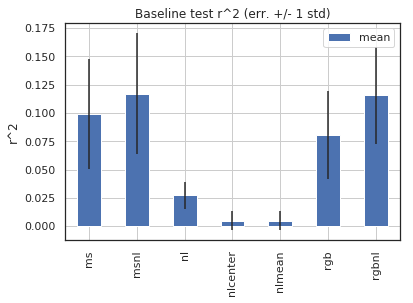

In [ ]:
r2s_df = results_byfold_df['r2'].unstack('bands').agg([np.median, np.mean, np.std]).T
colordisplay(r2s_df)

ax = r2s_df.plot(kind='bar', y='mean', yerr='std', grid=True)
ax.set_ylabel('r^2')
ax.set_title('Baseline test r^2 (err. +/- 1 std)')
plt.show()

## Single Model

In [ ]:
mask = {}
mask['test'] = (incountry_group_labels_aug == 0)
mask['val'] = (incountry_group_labels_aug == 4)
mask['train'] = ~(mask['test'] | mask['val'])

In [ ]:
preds = {split: [] for split in SPLITS}
results = train_linear_model(
    normalized_hists_diffs[mask['train']].reshape(np.sum(mask['train']), -1), labels_diffs_aug[mask['train']],
    normalized_hists_diffs[mask['val']].reshape(np.sum(mask['val']), -1), labels_diffs_aug[mask['val']])
best_model, preds['train'], preds['val'] = results

train	- r^2: 0.328, R^2: 0.286, mse: 0.089, rank: 0.513
val	- r^2: 0.134, R^2: 0.130, mse: 0.141, rank: 0.389
test	- r^2: 0.098, R^2: 0.096, mse: 0.137, rank: 0.290


/atlas/u/chrisyeh/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/atlas/u/chrisyeh/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  0.5*df, 0.5, np.fmin(np.asarray(df / (df + t_squared)), 1.0)


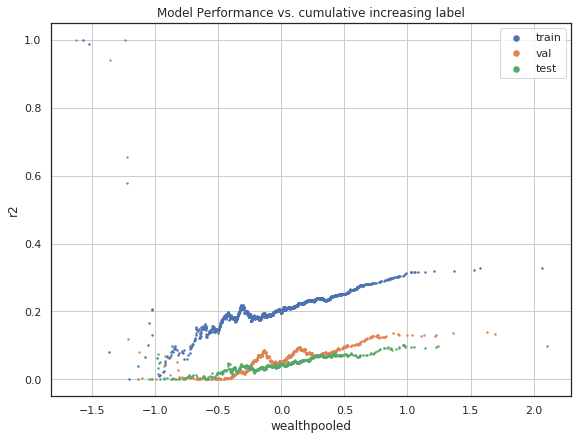

In [ ]:
preds['test'] = best_model.predict(normalized_hists_diffs[mask['test']].reshape(np.sum(mask['test']), -1))

for split in SPLITS:
    _ = evaluate(labels=labels_diffs_aug[mask[split]], preds=preds[split],
                 do_print=True, title=split)

cumulative_r2s = {}
labels_diffs_aug_sorted = {}
for split in SPLITS:
    cumulative_r2s[split], labels_diffs_aug_sorted[split] = sorted_scores(
        preds=preds[split], labels=labels_diffs_aug[mask[split]], metric='r2', sort='increasing')

plot_label_vs_score(
    scores_list=[cumulative_r2s[split] for split in SPLITS],
    labels_list=[labels_diffs_aug_sorted[split] for split in SPLITS],
    legends=SPLITS,
    metric='r2',
    sort='increasing')